コードのベースは
https://tellmoogle.hatenablog.com/entry/cokehigh_bayesian_optimization
を参考に作成

説明変数は2変数のみ使用可能

# ベイズ最適化
参考サイト  
ベイズ最適化による恩恵: https://datachemeng.com/post-3310/  
ベイズ最適化の概要  
https://www.slideshare.net/hoxo_m/ss-77421091  
https://www.slideshare.net/issei_sato/bayesian-optimization

![img](https://qiita-user-contents.imgix.net/https%3A%2F%2Fqiita-image-store.s3.amazonaws.com%2F0%2F146448%2Fa8e0f78a-275e-152d-0bd3-336743d9bfed.png?ixlib=rb-1.2.2&auto=format&gif-q=60&q=75&w=1400&fit=max&s=611d5c0ea8c4d36347051431a5d13d1e)

# 獲得関数について
色々あるが、以下の参考サイトによると下記の中では使う優先度としては、  
機械学習のパラメータチューニングとしてはMI>EI>UCB>PI、(この目的であればoptuna等を使うべき)  
実験計画法への活用としてはEI>UCB>PI>MIな印象を受けた。  

UCB,PIは自分でどの程度探索をするかのパラメータを決めなけれなならないので使いにくい。  
MIは過去の獲得関数の値を保持しておく必要があり、使いにくそう。

参考サイト  
概要:https://qiita.com/Bell-frontier/items/bf6425e40b0f9273cb12  

計算式の導出  
★https://cyberagent.ai/blog/research/10245/  
https://qiita.com/watakandai/items/c8abe4f80dab1cdace54  

<u>Upper Confidence Bound (maximize)</u>
$$
{UCB(\mathbf{x}) = \mu(\mathbf{x}) + \kappa\sigma(\mathbf{x})
}
$$
<u>Lower Confidence Bound (minimize)</u>
$$
{LCB(\mathbf{x}) = \mu(\mathbf{x}) - \kappa\sigma(\mathbf{x})
}
$$
*$\kappa$は探索をどれだけ重視するかの係数  
$\kappa=\sqrt{\frac{log(N)}{N}}$と置くことが多いよう。($N$はこれまでの実験数)

<u>Probability of Improvement (minimize)</u>
\begin{align} 
{\rm PI}({\bf x}) &= P(f({\bf x}) \leq f({\bf x}^{-})) \\ 
&= \int_{-\infty}^{f({\bf x}^{-})} \mathcal{N}(f({\bf x})|\mu_{\bf x}, \sigma_{\bf x}^2) \\ 
&= \Phi \Bigl( \frac{f({\bf x}^{-}) – \mu({\bf x})}{\sigma({\bf x})} \Bigr) 
\end{align}

上記の式だと活用を重視しすぎるため、探索をさせるための項として、trade-off parameter $ξ≥0$を用いる

\begin{align} 
{\rm PI}({\bf x}) &= P(f({\bf x}) \leq f({\bf x}^{-} – \xi)) \\ 
&= \int_{-\infty}^{f({\bf x}^{-}) – \xi} \mathcal{N}(f({\bf x})|\mu_{\bf x}, \sigma_{\bf x}^2) \\ 
&= \Phi \Bigl( \frac{f({\bf x}^{-})–\mu({\bf x})–\xi}{\sigma({\bf x})} \Bigr) 
\end{align}

<u>Expected Improvement (minimize)</u>  
$f^*$はこれまでのBest_value(下記の例では最小値)  
PIに比べて後ろの項があるので、探索をする。
$$
\begin{align}
EI(\mathbf{x}) &= (f^* - \mu(\mathbf{x}))\Phi(\frac{f^*-\mu(\mathbf{x})-\xi}{\sigma(\mathbf{x})}) + \sigma(\mathbf{x}) \phi(\frac{f^*-\mu(\mathbf{x})}{\sigma(\mathbf{x})})\\
&= (f^* - \mu(\mathbf{x}))PI(x) + \sigma(\mathbf{x}) \phi(\frac{f^*-\mu(\mathbf{x})}{\sigma(\mathbf{x})})
\end{align}
$$

<u>Mutual Information (maximize)</u>  
未実装。
$f^*$はこれまでのBest_value(下記の例では最大値)  

$$
{MI(\mathbf{x}) = \mu(\mathbf{x}) + \phi_t(\mathbf{x})}\\
\phi_t(\mathbf{x})=\sqrt{\alpha}(\sqrt{\sigma_t^2(x)+\hat{\gamma}_{t-1}}-\sqrt{\hat{\gamma}_{t-1}})\\
\gamma_0=0, \quad
\hat{\gamma}_{t}=\hat{\gamma}_{t-1}+\sigma_t^2(x)\\
\alpha = \frac{log(2)}{\delta} (0<\delta<1)
$$
論文では$\delta=10^{-6}$を基本として$10^{-9}\leq\delta\leq10^{-1}$でテストをしていた。

下記で実装できると思われる。同じxで繰り返す必要あり？そうなると同じxにおいてのgammaをどう保持していくかが結構面倒。  
MLのパラメータチューニングのようにすぐ試行を繰り返せるなら、いいが実験のように試行に時間がかかるのには難しい。
  
        """   
        elif self.acq_name=="MI":
            delta=10**(-6)
            alpha=np.log(2)/delta

            # gammaが定義されているかを確認。なければ初期値0を与える。
            try:
                self.gamma
            except:
                self.gamma=0

            # MIの計算                
            gamma=self.gamma
            phi=np.sqrt(alpha)*np.sqrt((sigma**2+gamma)-np.sqrt(gamma))
            MI = y_mean + phi            
            self.gamma+=sigma**2
            return MI   
        """

## EIについて

### 最小化の時
指示関数を下記の通り定義します。
$$
{I(x) = \max(f^*-f(x),0)}\\
$$
$f^∗$は現在の最小値，$f(x)$は確率変数$∼N(μ,σ^2)$とします．  
ここで$f$は確率変数なので平均を評価するために$I(x)$の期待値をとります．  
特定の$x$について、獲得関数を計算するため、$f^∗,\mu,\sigma$は定数になります.

$$
{\begin{align}
EI(x) & =  E_{f(x)\sim \mathcal{N}(\mu, \sigma^2)}[I(x)] \\ 
& = E_{\epsilon\sim \mathcal{N}(0,1)}[I(x)]  \quad ∵\epsilon=\frac {f(x)-\mu}{\sigma}
⇔f(x)=\mu+\sigma\epsilon, \quad ϵ∼N(0,1)\\   
& = \int_{-\infty}^{\infty} I(x) \phi(\epsilon) d\epsilon \\
& = \int_{-\infty}^{(f^*-\mu)/\sigma} (f^* - \mu - \sigma \epsilon) \phi(\epsilon) d\epsilon \\
& = (f^* - \mu)\int_{-\infty}^{(f^*-\mu)/\sigma}\phi(\epsilon) d\epsilon - \sigma \int_{-\infty}^{(f^*-\mu)/\sigma} \epsilon \phi(\epsilon) d\epsilon \\
& = (f^* - \mu)\Phi(\frac{f^*-\mu}{\sigma}) - \sigma \int_{-\infty}^{(f^*-\mu)/\sigma} \epsilon \phi(\epsilon) d\epsilon \\
\end{align} 
}
$$

以降は後ろの項について考える。

$ϕ(ϵ)$に$ϵ∼N(0,1)$を代入  
$\phi(\epsilon) = \frac{1}{\sqrt{2\pi}} \exp (-\frac{\epsilon^2}{2})$\
$$
\begin{align}
EI(x) & = (f^* - \mu)\Phi(\frac{f^*-\mu}{\sigma}) + \frac{\sigma}{
\sqrt{2\pi}} \int_{-\infty}^{(f^*-\mu)/\sigma} (-\epsilon) e^{-\epsilon^2/2} d\epsilon \\
& = (f^* - \mu)\Phi(\frac{f^*-\mu}{\sigma}) + \frac{\sigma}{
\sqrt{2\pi}}  e^{-\epsilon^2/2}|_{-\infty}^{(f^*-\mu)/\sigma} \\
& = (f^* - \mu)\Phi(\frac{f^*-\mu}{\sigma}) + \sigma \big(\phi(\frac{f^*-\mu}{\sigma}) - 0\big)\\
& = (f^* - \mu)\Phi(\frac{f^*-\mu}{\sigma}) + \sigma \phi(\frac{f^*-\mu}{\sigma})\\
\end{align}
$$

ガウス過程で得られた$n+1$番目の平均$mu_{n+1}(x)$と分散$σ_{n+1}(x)$を使って以下の獲得関数を更新します．

$$
{EI(x) = (f^* - \mu)\Phi(\frac{f^*-\mu}{\sigma}) + \sigma \phi(\frac{f^*-\mu}{\sigma})
}
$$
下記の実装では
$$
imp=f^* - \mu, \quad  Z=\frac{imp}{\sigma}とおき、
{EI(x) = (imp)\Phi(Z) + \sigma \phi(Z)
}
$$
としている。

### 最大化の時
指示関数を下記の通り定義します。
$$
{I(x) = \max(f(x)-f^*,0)}\\
$$
$f^∗$は現在の<u>最大値</u>，$f(x)$は確率変数$∼N(μ,σ^2)$とします．  
ここで$f$は確率変数なので平均を評価するために$I(x)$の期待値をとります．

$$
{\begin{align}
EI(x) & =  E_{f(x)\sim \mathcal{N}(\mu, \sigma^2)}[I(x)] \\ 
& = E_{\epsilon\sim \mathcal{N}(0,1)}[I(x)]   \quad
∵\epsilon=\frac {f(x)-\mu}{\sigma}
⇔f(x)=\mu+\sigma\epsilon, \quad ϵ∼N(0,1)\\
& = \int_{-\infty}^{\infty} I(x) \phi(\epsilon) d\epsilon\\
& = \int_{(f^*-\mu)/\sigma}^{\infty} (\mu + \sigma \epsilon - f^*) \phi(\epsilon) d\epsilon \\
& =  (\mu - f^*)\int_{-\infty}^{(\mu-f^*)/\sigma} \phi(\epsilon) d\epsilon + \sigma \int_{-\infty}^{(\mu-f^*)/\sigma} -\epsilon \phi(\epsilon) d\epsilon    \quad
∵\epsilon→ -\epsilon, \quad \phi(-\epsilon)=\phi(\epsilon)\\
& = (\mu - f^*)\Phi(\frac{\mu-f^*}{\sigma}) - \sigma \int_{-\infty}^{(\mu-f^*)/\sigma} \epsilon \phi(\epsilon) d\epsilon \\
\end{align} 
}
$$

以降は後ろの項について考える。

$ϕ(ϵ)$に$ϵ∼N(0,1)$を代入  
$\phi(\epsilon) = \frac{1}{\sqrt{2\pi}} \exp (-\frac{\epsilon^2}{2})$\
$$
{\begin{align}
EI(x) & = (\mu - f^*)\Phi(\frac{\mu-f^*}{\sigma}) + \frac{\sigma}{
\sqrt{2\pi}} \int_{-\infty}^{(\mu-f^*)/\sigma} (-\epsilon) e^{-\epsilon^2/2} d\epsilon \\
& =  (\mu - f^*)\Phi(\frac{\mu-f^*}{\sigma})  + \frac{\sigma}{
\sqrt{2\pi}}  e^{-\epsilon^2/2}|_{-\infty}^{(\mu-f^*)/\sigma} \\
& =  (\mu - f^*)\Phi(\frac{\mu-f^*}{\sigma}) + \sigma \big( \phi(\frac{\mu-f^*}{\sigma})-0) \big)\\
& =  (\mu - f^*)\Phi(\frac{\mu-f^*}{\sigma})  + \sigma \phi(\frac{\mu-f^*}{\sigma})\\
\end{align} 
}
$$

下記で実装できる。
$$
imp=\mu-f^*, \quad  Z=\frac{imp}{\sigma}とおき、
{EI(x) = (imp)\Phi(Z) + \sigma \phi(Z)
}
$$

## MIについて
UCBのσ部分を前回のσとの差分を考え、情報更新量とする。UCBでは同じ点を何度も探索するので、それを防ぐための考えだと思われる。  
https://datachemeng.com/bayesianoptimization/  
http://proceedings.mlr.press/v32/contal14.pdf

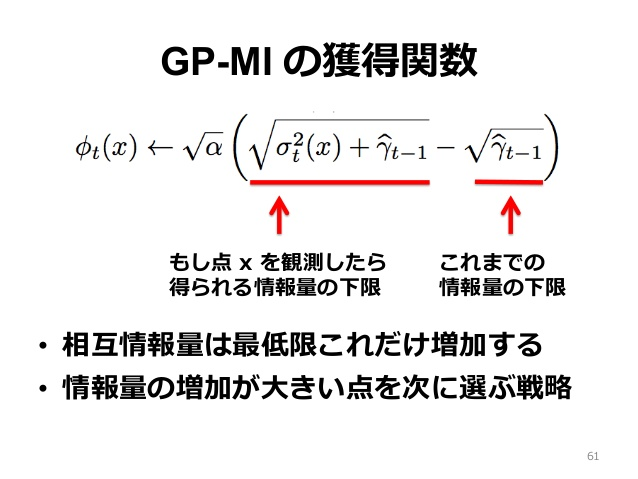

# ライブラリのインポート

In [1]:
import GPy
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.cm import ScalarMappable
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
import sys

# 初期データ及び獲得関数の設定

最低限二つのデータが必要なので二つ以上のデータを作る  
獲得関数(acq_name)はEI,UCB,LCB, PIを実装  
kernelは`GPy.kern.RBF(dim) + GPy.kern.White(dim)`を使用。

In [2]:
# 動かすx,yの範囲
# 範囲を広げると計算量が増えるので変えない方がいいと思う。
# なるべく関数を変えて実験してください。
min_x=-1
max_x=1

# 使用する獲得関数
acq_name="EI"

#最大化をするか最小化をするか
#orientation="maximize"
orientation="maximize"

# 最初にランダムで与える実験の数 (2以上)
rand_num=2

# 最初に適当に実験データを作る
df_origin = pd.DataFrame(np.random.rand(rand_num, 2)*(max_x-min_x)+min_x)
list_x = ["x1", "x2"]
df_origin.columns = list_x

In [3]:
# 作られたデータの内容を上から5行目まで表示
df_origin

,x1,x2
0,0.884602,-0.597098
1,0.744936,0.058618


In [4]:
x = np.array(df_origin)

# 最大化を目的として実験すべき値を提案するクラスの作成
実験して結果を得るイメージ  
*下記のコードにはf(x)を定義しているが、モガウス過程回帰デルにはx,yしか与えないのでどのような関数が用いられているかわからない。

In [5]:
class bayesian_optimization:
    """
    min_x,max_x:integer.
    acq_name:string. "EI","UCB","LCB","PI"
    orientation:string. "maximize" or "minimize"
    """
    def __init__(self, min_x, max_x, acq_name, orientation="maximize"):
        self.min_x = min_x
        self.max_x = max_x
        self.acq_name = acq_name
        self.orientation = orientation
        print("initialized")

    def f(self, x):
        """
        yとxの関係を表す関数
        実際の関数にノイズを乗せている。
        ノイズを乗せないと同じ実験候補が上がった時に全く同じデータになるため、エラーになる。
        (エラーになる理由は全く同じ行ができて、逆行列が計算できなくなるから？σが部分的に0になる？)
        k(x,x')でカーネル行列が作られているので、全く同じxがあれば逆行列が計算できなくなる気がするが、
        yにノイズを載せておけばエラーにならない。)
        """
        x1 = x[:, 0]
        x2 = x[:, 1]

        # xとyの関係性
        f = x1**3*(-1)+x1**2+x2+np.sin(np.pi*x2)
        # 観測誤差
        noise = np.random.normal(size=len(x))*0.1
        return f + noise

    def plot_f(self):
        # f(x)の表示
        x1 = np.linspace(self.min_x, self.max_x, 30)
        x2 = np.linspace(self.min_x, self.max_x, 30)

        X1, X2 = np.meshgrid(x1, x2)

        Y = self.f(np.array([X1.ravel(), X2.ravel()]).T)

        Y = Y.reshape(30, 30)

        # プロット
        plt.xlabel("x1")
        plt.ylabel("x2")
        plt.title('Y')
        plt.contourf(X1, X2, Y, cmap='jet', levels=int(
            (self.max_x-self.min_x)/0.1))
        plt.colorbar()

        return plt

    def Gaussian_process_regression(self, x, y, graph_plot=True):
        """入力の整形"""
        x_train = np.array(x)
        y_train = np.array(y)

        """既知のデータをもとにガウス過程回帰"""
        # 入力データの次元数
        dim = 2
        kern = GPy.kern.RBF(dim) + GPy.kern.White(dim)  # , ARD=True)
        gpy_model = GPy.models.GPRegression(X=x_train.reshape(-1, 2),
                                            Y=y_train.reshape(-1, 1),
                                            kernel=kern,
                                            normalizer=True)
        gpy_model.optimize()  # カーネル最適化
        
        if graph_plot:
            """モデルの可視化"""
            fig = plt.figure(figsize=(10, 6))
            ax = fig.add_subplot(111)

            gpy_model.plot_mean(ax=ax, cmap="jet")  # カーネル最適化後の予測

            """データ点の描画(defaultでは見辛い)"""
            [ax.plot(xi, yi, marker=".", color="k", markersize=10)
             for xi, yi in zip(x_train[:, 0], x_train[:, 1])]
            ax.set_xlabel(list_x[0], fontsize=20)
            ax.set_ylabel(list_x[1], fontsize=18)
            ax.tick_params(labelsize=20)

            """color bar追加"""
            axpos = ax.get_position()
            cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.8])
            norm = colors.Normalize(vmin=y_train.min(), vmax=y_train.max())
            mappable = ScalarMappable(cmap='jet', norm=norm)
            cbar_ax.tick_params(labelsize=10)
            fig.colorbar(mappable, cax=cbar_ax)

            # plt.savefig(f"2dim_gaussian_n={n}.png")

        return gpy_model

    def make_trial_list(self, x, step):
        """
        実験すべき値を検証するためのリスト作成
        """
        trial_list = np.arange(self.min_x, self.max_x+step, step)
        return trial_list

    def acquisition_function(self, y_mean, y_best, sigma, n):
        if self.acq_name == "UCB":
            # σにかける係数をkとする
            k = np.sqrt(np.log(n)/n)
            #k = 1
            if orientation == "maximize":
                UCB = y_mean + k*sigma
                return UCB

            elif orientation == "minimize":
                print("Use LCB when you want to minimize.")

            else:
                print("The specified acquisition function does not exist.")
                sys.exit()

        if self.acq_name == "LCB":
            # σにかける係数をkとする
            k = np.sqrt(np.log(n)/n)
            #k = 1
            if orientation == "minimize":
                LCB = y_mean - k*sigma
                # 獲得関数の最大のところを探索するようにしているので、負にする。argmin→argmax
                return -LCB

            elif orientation == "maximize":
                print("Use UCB when you want to maximize.")

            else:
                print("The specified acquisition function does not exist.")
                sys.exit()

        elif self.acq_name == "EI":
            xi = 0.01  # ハイパーパラメータ、小さいとき活用を重視、大きいとき探索を重視、0.01くらいがいいらしい
            # sigmaで割るのでsigma=0の時は警告を無視して、ei=0とする
            with np.errstate(divide='warn'):
                if orientation == "maximize":
                    imp = y_mean - y_best - xi
                    Z = imp / sigma
                    EI = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
                    EI[sigma == 0] = 0  # σが0の時は0にする。
                    return EI

                elif orientation == "minimize":
                    imp = y_best - y_mean - xi
                    Z = imp / sigma
                    EI = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
                    EI[sigma == 0] = 0  # σが0の時は0にする。
                    return EI
                
                else:
                    print("The specified acquisition function does not exist.")
                    sys.exit()

        elif self.acq_name == "PI":
            xi = 0.1  # 改善確率を計算するときに標準偏差にかける係数
            with np.errstate(divide='warn'):
                if orientation == "maximize":
                    imp = y_mean - y_best - xi
                elif orientation == "minimize":
                    imp = y_best - y_mean - xi
                else:
                    print("The specified acquisition function does not exist.")
                    sys.exit()
                Z = imp / sigma
                PI = norm.cdf(Z)
                PI[sigma == 0] = 0
                return PI

    def suggest_next_trial(self, x, gpy_model, y_best, x1_step=0.05, x2_step=0.05, graph_plot=True):
        """
        作った回帰モデルをもとに新たな入力xに対する出力yをみて
        獲得関数acqを最大化する点(=次に実験を行うべき条件)を探す。
        """
        x = np.array(x)
        n = len(x)

        # step刻みで1つ目の変数の配列を作成
        x1 = self.make_trial_list(x[:, 0], x1_step)

        # step刻みで2つ目の変数の配列を作成
        x2 = self.make_trial_list(x[:, 1], x2_step)

        # 格子点を作成
        xx1, xx2 = np.meshgrid(x1, x2)

        # 格子点のリストとして表現
        X = np.array([xx1.ravel(), xx2.ravel()]).T

        # 予測値、分散値を取得
        y_mean, y_var = gpy_model.predict(X)
        sigma = np.sqrt(y_var)

        # acqの最大値の候補を算出
        acq_list = self.acquisition_function(y_mean, y_best, sigma, n)
        next_x = X[acq_list.argmax()]
        
        if graph_plot:
            """ x2の入力を1次元固定してプロット"""
            x_pred = np.array([x1, np.full(len(x1), next_x[1])]).T
            y_mean, y_var = gpy_model.predict(x_pred)
            sigma = np.sqrt(y_var)

            fig = plt.figure(figsize=(10, 8))
            ax1 = fig.add_subplot(211)

            gpy_model.plot(fixed_inputs=[(1, next_x[1])], plot_data=True, ax=ax1)
            ax1.set_xlabel(list_x[0], fontsize=14)
            ax1.set_ylabel("score", fontsize=14)

            """獲得関数acq"""
            acq = self.acquisition_function(y_mean, y_best, sigma, n)

            """獲得関数の可視化"""
            ax1_twin = ax1.twinx()
            ax1_twin.plot(x1, acq, color="g", label="Acquisition")
            if orientation=="maximize":
                ax1_twin.plot(x1[acq.argmax()], acq.max(),
                          marker=".", color="r", markersize=14, label="Acq Max")
            ax1_twin.set_ylabel("Acqisition")

            # handsにはlabelが指定された曲線オブジェクトのリスト、
            # labsには対応するlabelのリストが入る
            hans1, labs1 = ax1.get_legend_handles_labels()
            hans2, labs2 = ax1_twin.get_legend_handles_labels()
            plt.legend(handles=hans1+hans2, labels=labs1+labs2)

            """ x1の入力を1次元固定して予測"""
            x_pred = np.array([np.full(len(x2), next_x[0]), x2]).T
            y_mean, y_var = gpy_model.predict(x_pred)
            sigma = np.sqrt(y_var)

            ax2 = fig.add_subplot(212)
            gpy_model.plot(fixed_inputs=[(0, next_x[0])], plot_data=True, ax=ax2)
            ax2.set_xlabel(list_x[1], fontsize=14)
            ax2.set_ylabel("score", fontsize=14)

            """獲得関数acq"""
            acq = self.acquisition_function(y_mean, y_best, sigma, n)

            """獲得関数の可視化"""
            ax2_twin = ax2.twinx()
            ax2_twin.plot(x2, acq, color="g", label="Acquisition")
            ax2_twin.plot(x2[acq.argmax()], acq.max(),
                          marker=".", color="r", markersize=14, label="Acq Max")
            ax2_twin.set_ylabel("Acqisition")
            hans1, labs1 = ax2.get_legend_handles_labels()
            hans2, labs2 = ax2_twin.get_legend_handles_labels()
            plt.legend(handles=hans1+hans2, labels=labs1+labs2)

            # plt.savefig(f"1dim_gaussian_n={n}_x2={next_x2}.png")

            print("Next Trial:")
            print(str(list_x[0])+":", next_x[0])
            print(str(list_x[1])+":", next_x[1])

        return next_x

    def update_and_suggest_next_trial(self, x, next_data):
        """
        下記はコメントアウト。docstringではないので、注意。
        
        # 過去に試したデータと同じものを提案した場合終了とする。
        unique_array, counts = np.unique(
            np.vstack([x, next_data]), axis=0, return_counts=True)
        if counts.max() > 1:
            print("{}は実験済みのデータです。試行を終了します。".format(next_data))

        else:
            x = np.vstack([x, next_data])
            y = self.f(x)
            y_best=y.max()

            gpy_model = self.Gaussian_process_regression(x, y)
            next_data = self.suggest_next_trial(
                x, gpy_model, y_best, x1_step=0.05, x2_step=0.05)
        """

        x = np.vstack([x, next_data])
        y = self.f(x)
        y_best = y.max()

        gpy_model = self.Gaussian_process_regression(x, y)
        next_data = self.suggest_next_trial(
            x, gpy_model, y_best, x1_step=0.05, x2_step=0.05)

        return x, next_data
    
    def compare_acq_function(self,x,y,iteration):
        """
        獲得関数の差を見る。
        iteration:試行回数
        """
        dim=x.shape[1]

        
        if orientation=="maximize":
            CB="UCB"
        elif orientation=="minimize":
            CB="LCB"
        acq_name_list=["EI",CB,"PI"]
        
        df_y=pd.DataFrame()
        for acq_name in acq_name_list:
            x_new=x.copy()
            y_new=y.copy()            
            for i in range(iteration):                
                gpy_model = self.Gaussian_process_regression(x_new, y_new, graph_plot=False)
                next_data = test.suggest_next_trial(x_new, gpy_model, y_new.max(), graph_plot=False)
                y_next=self.f(next_data.reshape(-1,dim))[0]
                x_new= np.vstack([x_new, next_data])
                y_new=np.append(y_new,y_next)
            df_y[acq_name]=y_new
            plt.scatter(x_new[:,0],x_new[:,1],label=acq_name)
        plt.xlabel("x1")
        plt.ylabel("x2")
        plt.legend()
        plt.title("X experimented with each acquisition function")
        plt.show()
        return df_y

# 最大化または最小化する関数の可視化

initialized


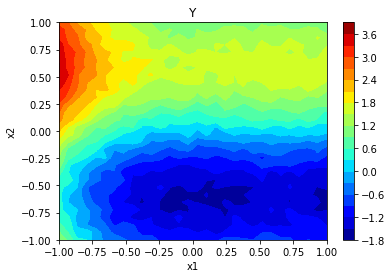

In [6]:
# classのインスタンス化
test=bayesian_optimization(min_x,max_x,acq_name)
plt=test.plot_f()
plt.show()

# 初期実験値の入力
y=test.f(x)

# 獲得関数の違いによる結果の比較

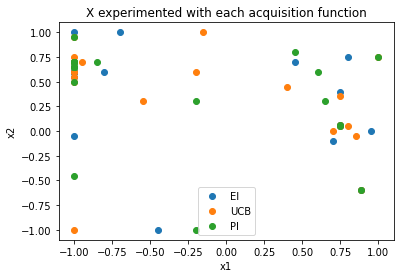

In [7]:
iteration=20
df_y=test.compare_acq_function(x,y,iteration)

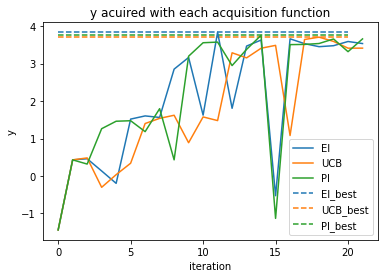

In [46]:
cmap = plt.get_cmap("tab10")
df_y.plot(title="y acuired with each acquisition function", xlabel="iteration",ylabel="y")
plt.hlines(df_y["EI"].max(),0,iteration,linestyles='dashed', colors=cmap(0),label="EI_best")
plt.hlines(df_y["UCB"].max(),0,iteration,linestyles='dashed', colors=cmap(1),label="UCB_best")
plt.hlines(df_y["PI"].max(),0,iteration,linestyles='dashed', colors=cmap(2),label="PI_best")
plt.legend()
plt.show()

## Gridsearchで最適解を求める

In [9]:
step=0.05

# step刻みで1つ目の変数の配列を作成
x1 = np.linspace(min_x,max_x,int((max_x-min_x)/step+1))

# step刻みで2つ目の変数の配列を作成
x2 = x1.copy()

# 格子点を作成
xx1, xx2 = np.meshgrid(x1, x2)

# 格子点のリストとして表現
X = np.array([xx1.ravel(), xx2.ravel()]).T
Y=test.f(X)
if orientation=="maximize":
    print("最適実験データは{}です。".format(X[Y.argmax()]))
elif orientation=="minimize":
    print("最適実験データは{}です。".format(X[Y.argmin()]))
else:
    print("orientationの指定が間違っています。")

最適実験データは[-1.   0.5]です。


# 最初のモデル

 C:\Users\183787\AppData\Roaming\Python\Python37\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


GP_regression.,value,constraints,priors
sum.rbf.variance,0.018040493073062276,+ve,
sum.rbf.lengthscale,0.14580135602838123,+ve,
sum.white.variance,0.4909850292317142,+ve,
Gaussian_noise.variance,0.4909850292317142,+ve,


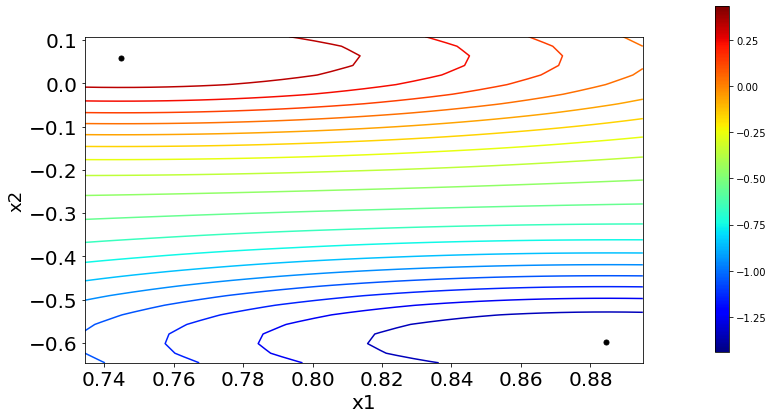

In [10]:
gpy_model = test.Gaussian_process_regression(x,y)
gpy_model

↓少し見にくいがこれでも可能

## 実験候補の表示

{'dataplot': [<matplotlib.collections.PathCollection at 0x1f383938748>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1f383beac48>]}

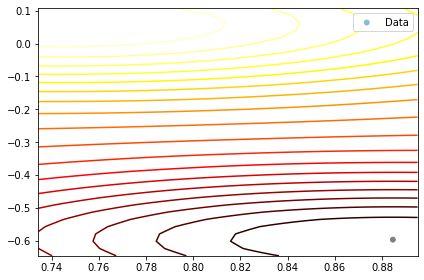

In [11]:
gpy_model.plot()

## 実験をして更新していく

Next Trial:
x1: 0.7500000000000016
x2: 0.05000000000000093


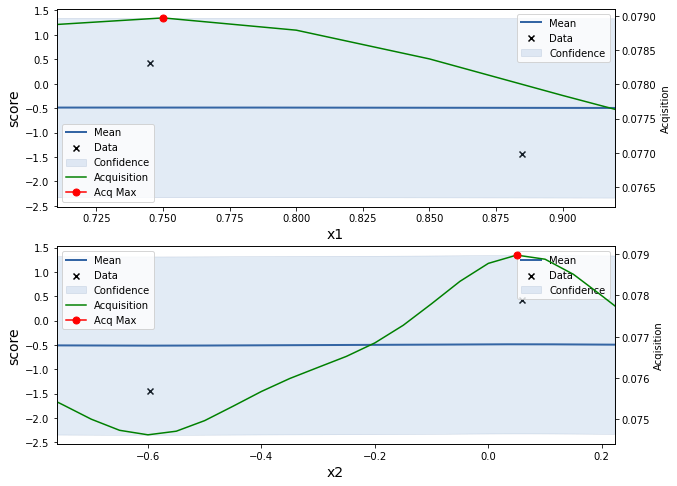

In [12]:
next_data=test.suggest_next_trial(x, gpy_model, y.max())

上記の通りデータを増やしてみる

 C:\Users\183787\AppData\Roaming\Python\Python37\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


Next Trial:
x1: 0.6000000000000014
x2: 0.30000000000000115


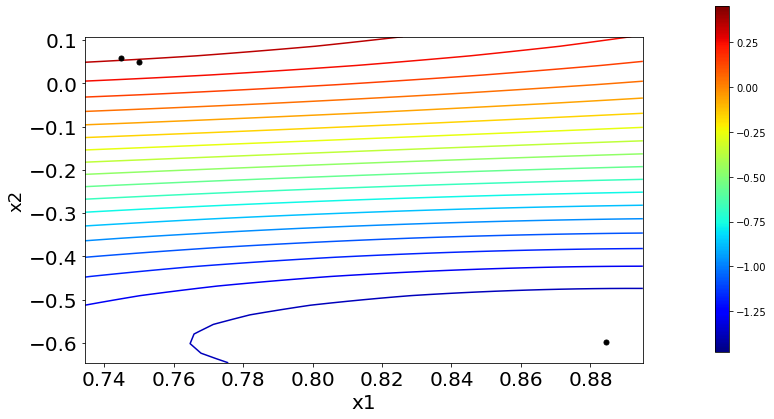

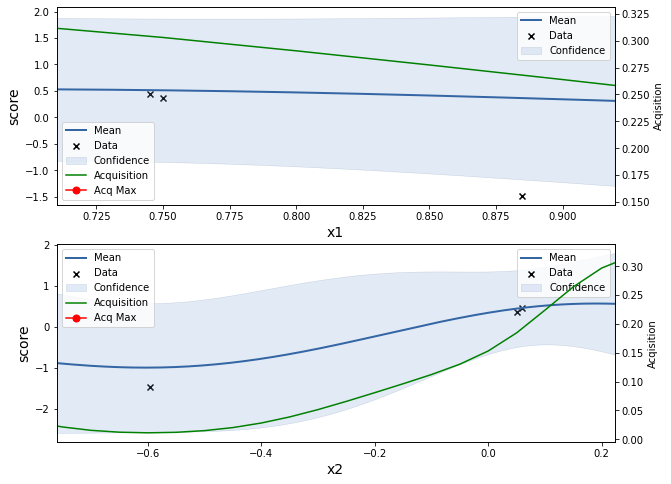

In [13]:
x, next_data = test.update_and_suggest_next_trial(x,next_data)

 C:\Users\183787\AppData\Roaming\Python\Python37\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


Next Trial:
x1: 0.5500000000000014
x2: 0.3500000000000012


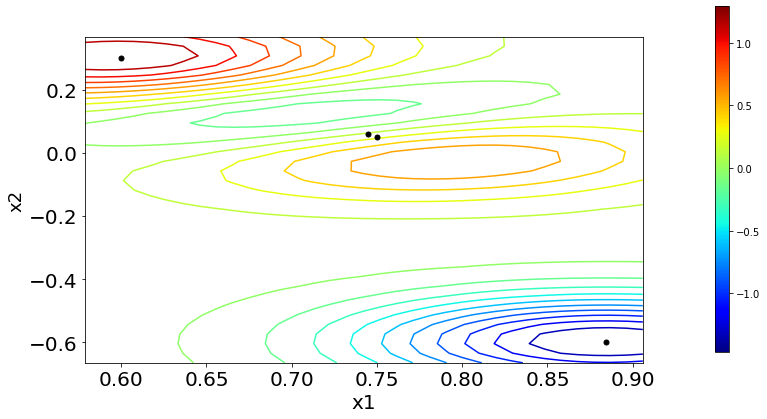

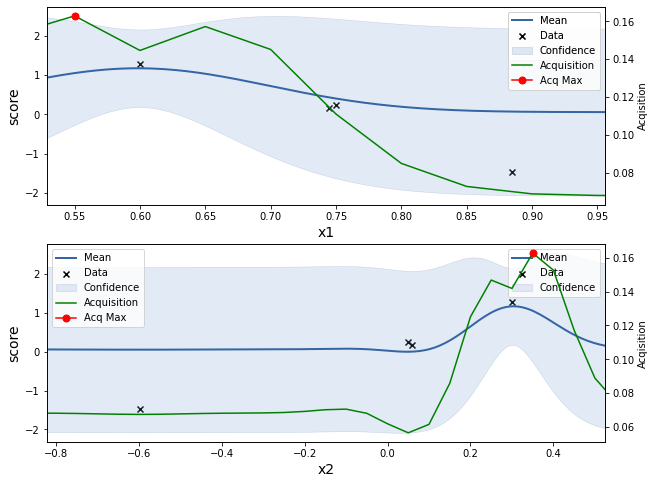

In [14]:
x, next_data = test.update_and_suggest_next_trial(x,next_data)

 C:\Users\183787\AppData\Roaming\Python\Python37\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


Next Trial:
x1: 0.6000000000000014
x2: 1.0000000000000018


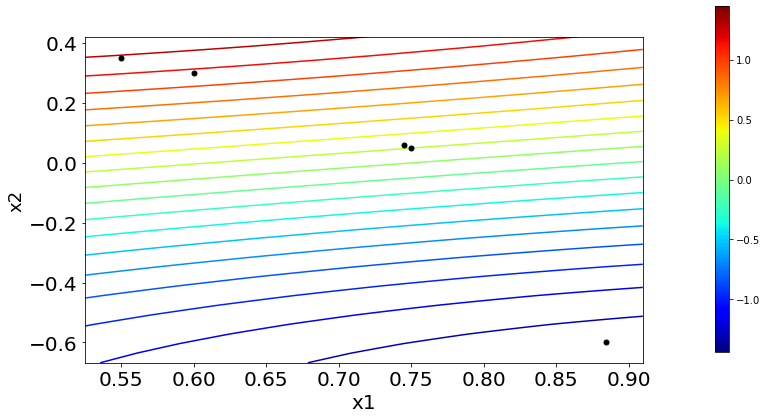

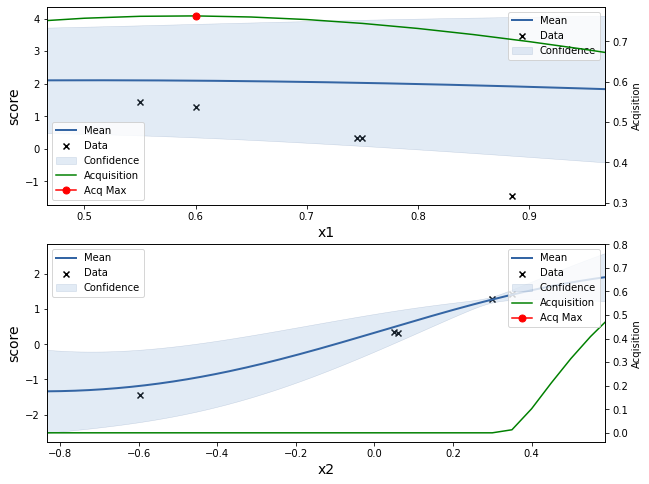

In [15]:
x, next_data = test.update_and_suggest_next_trial(x,next_data)

 C:\Users\183787\AppData\Roaming\Python\Python37\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


Next Trial:
x1: -0.14999999999999925
x2: 0.5000000000000013


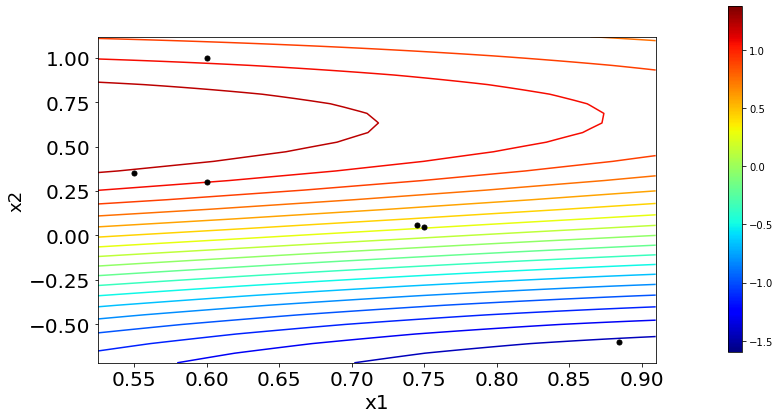

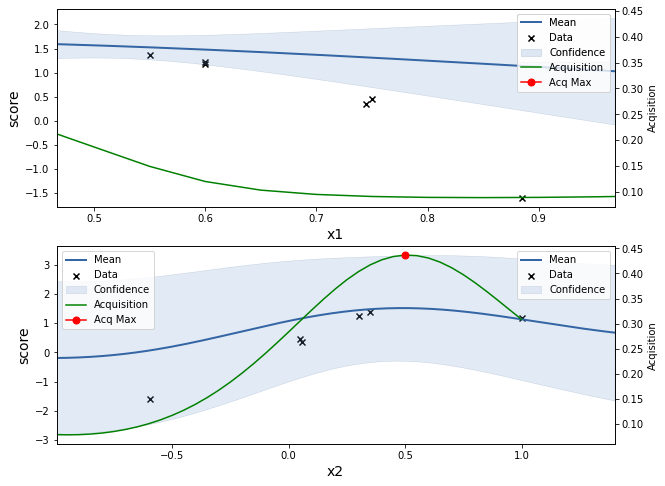

In [16]:
x, next_data = test.update_and_suggest_next_trial(x,next_data)

 C:\Users\183787\AppData\Roaming\Python\Python37\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


Next Trial:
x1: 0.20000000000000107
x2: 0.5000000000000013


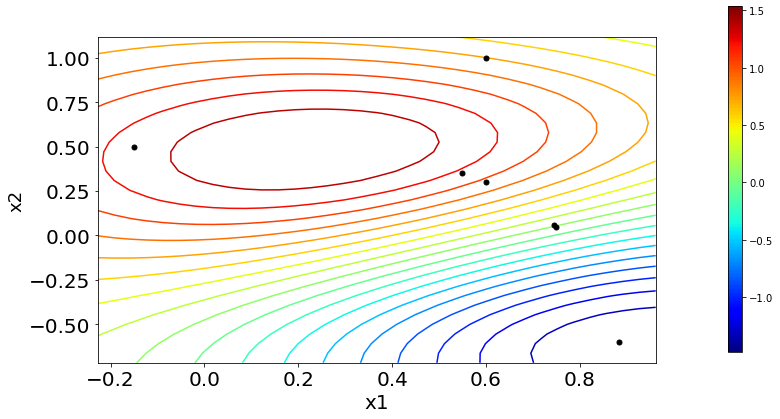

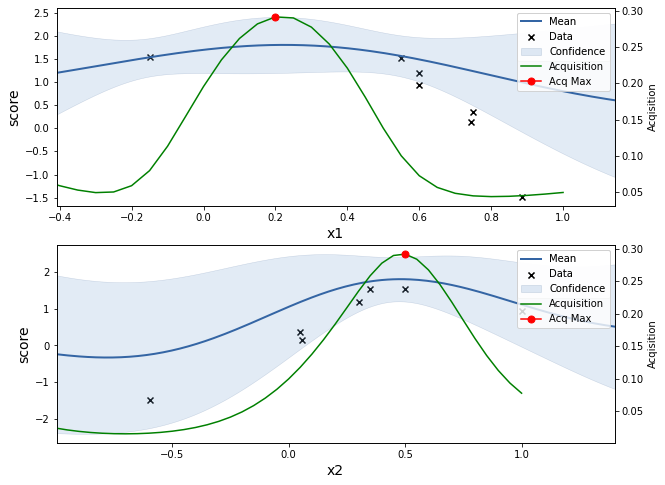

In [17]:
x, next_data = test.update_and_suggest_next_trial(x,next_data)

 C:\Users\183787\AppData\Roaming\Python\Python37\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


Next Trial:
x1: -0.95
x2: 0.2500000000000011


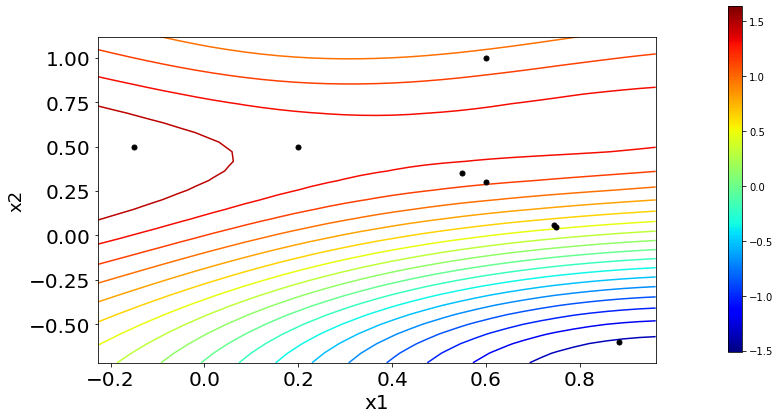

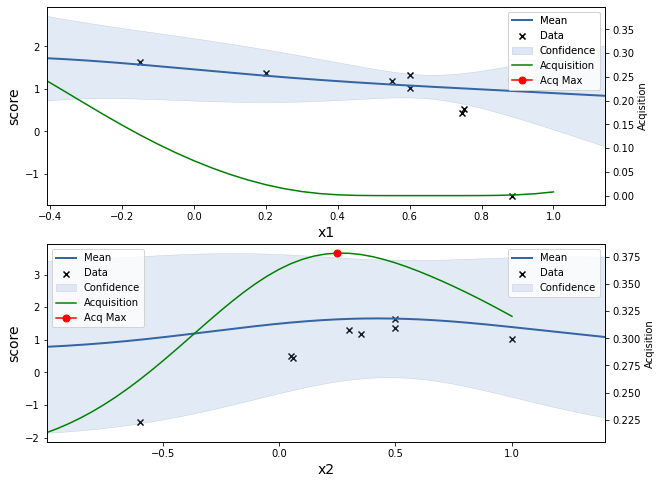

In [18]:
x, next_data = test.update_and_suggest_next_trial(x,next_data)

 C:\Users\183787\AppData\Roaming\Python\Python37\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


Next Trial:
x1: -1.0
x2: -0.2999999999999994


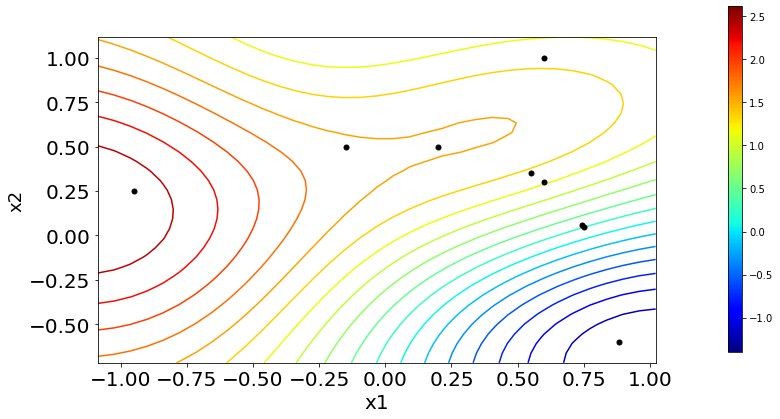

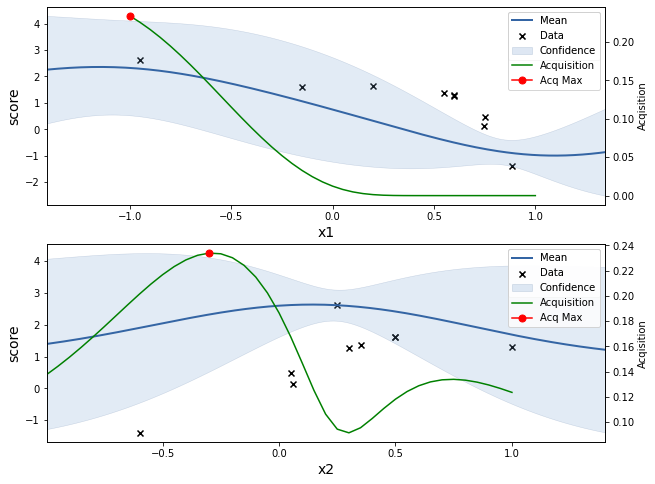

In [19]:
x, next_data = test.update_and_suggest_next_trial(x,next_data)

 C:\Users\183787\AppData\Roaming\Python\Python37\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


Next Trial:
x1: -1.0
x2: 0.6000000000000014


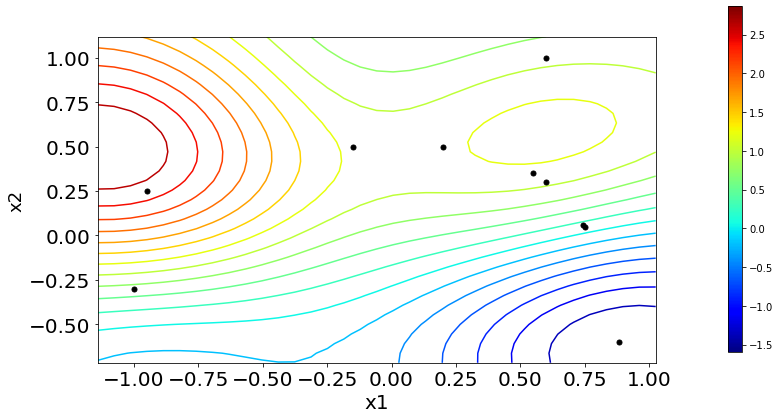

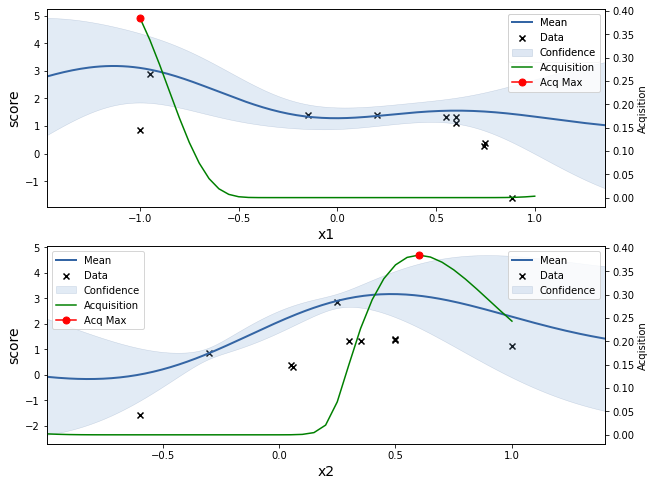

In [20]:
x, next_data = test.update_and_suggest_next_trial(x,next_data)

 C:\Users\183787\AppData\Roaming\Python\Python37\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


Next Trial:
x1: -1.0
x2: 1.0000000000000018


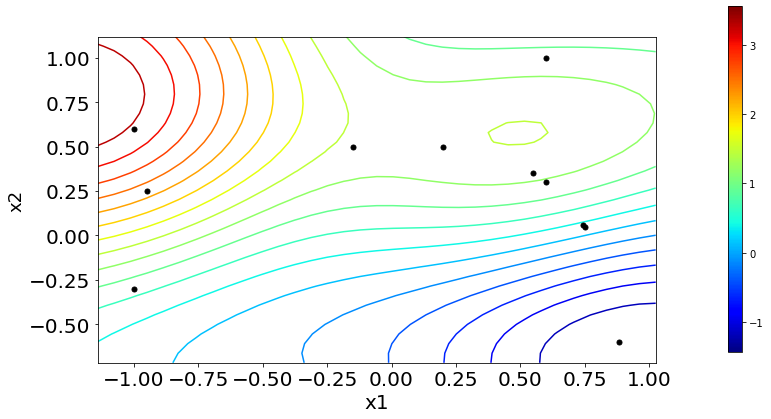

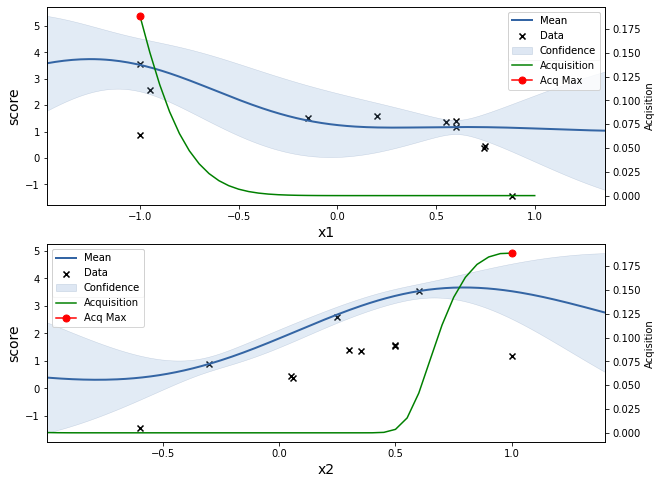

In [21]:
x, next_data = test.update_and_suggest_next_trial(x,next_data)

 C:\Users\183787\AppData\Roaming\Python\Python37\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


Next Trial:
x1: -1.0
x2: 0.6500000000000015


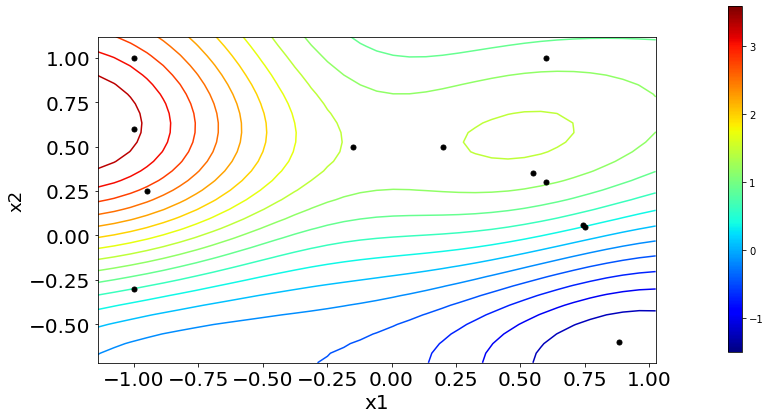

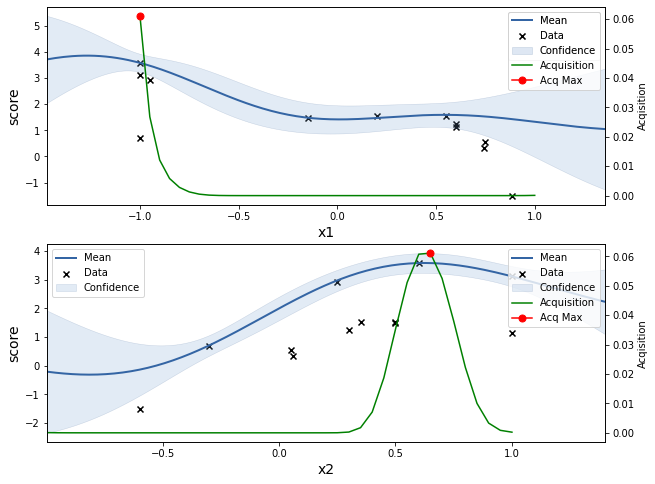

In [22]:
x, next_data = test.update_and_suggest_next_trial(x,next_data)

 C:\Users\183787\AppData\Roaming\Python\Python37\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


Next Trial:
x1: -1.0
x2: 0.6500000000000015


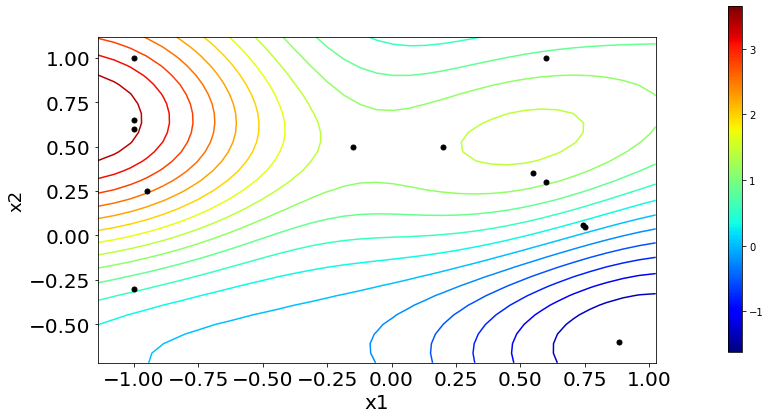

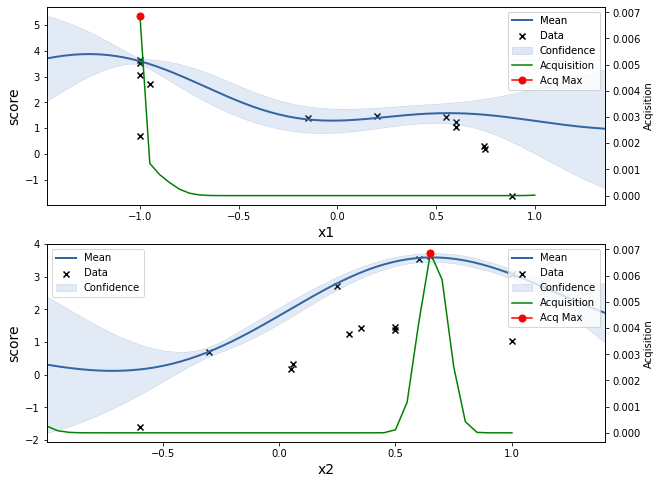

In [23]:
x, next_data = test.update_and_suggest_next_trial(x,next_data)

 C:\Users\183787\AppData\Roaming\Python\Python37\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


Next Trial:
x1: -0.24999999999999933
x2: -1.0


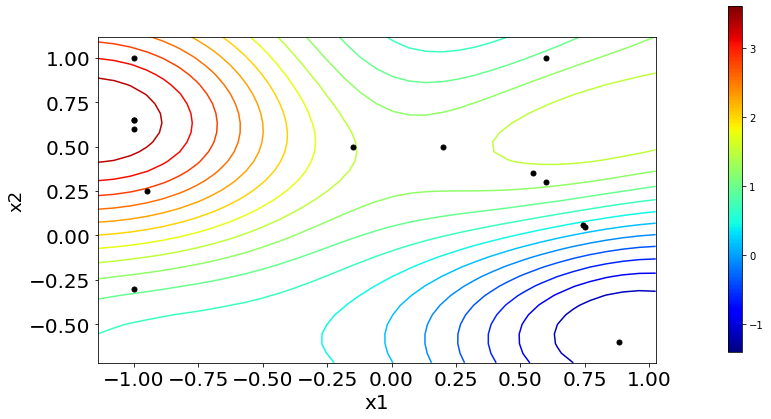

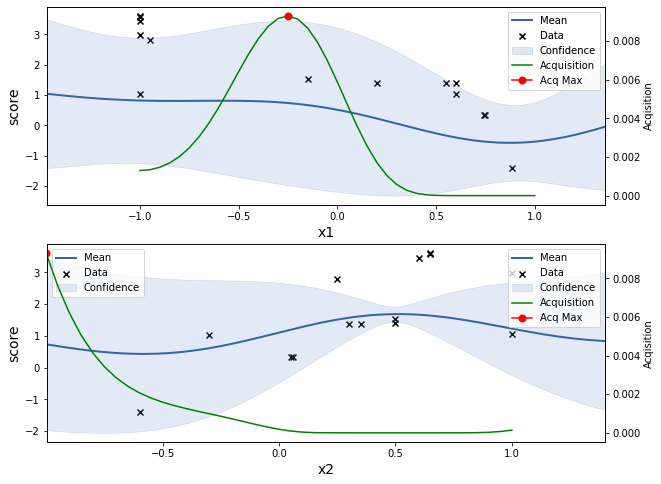

In [24]:
x, next_data = test.update_and_suggest_next_trial(x,next_data)

 C:\Users\183787\AppData\Roaming\Python\Python37\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


Next Trial:
x1: -1.0
x2: 0.6000000000000014


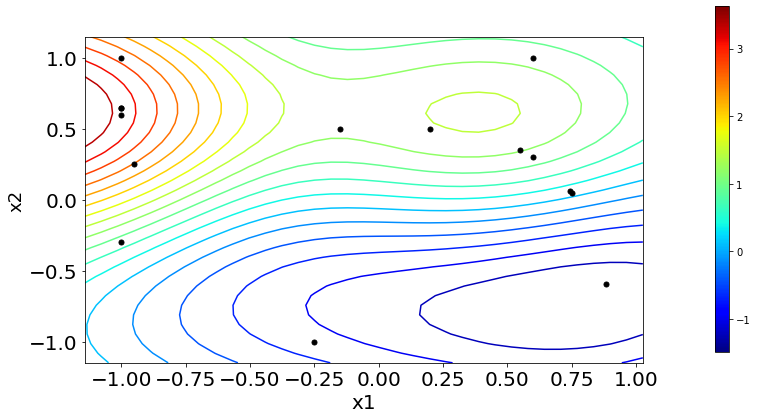

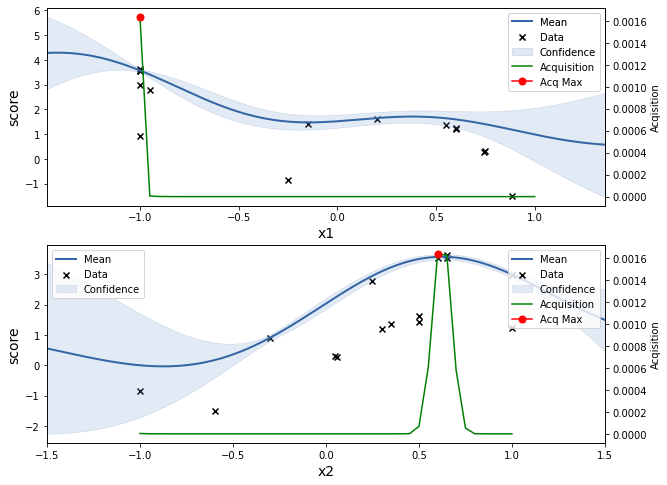

In [25]:
x, next_data = test.update_and_suggest_next_trial(x,next_data)

 C:\Users\183787\AppData\Roaming\Python\Python37\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


Next Trial:
x1: -1.0
x2: 0.6000000000000014


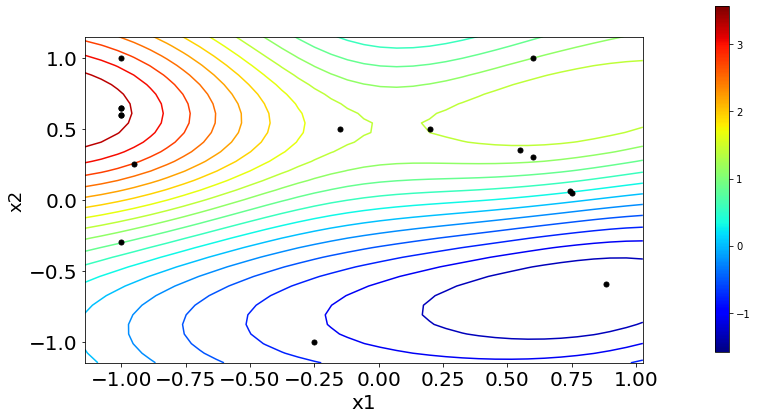

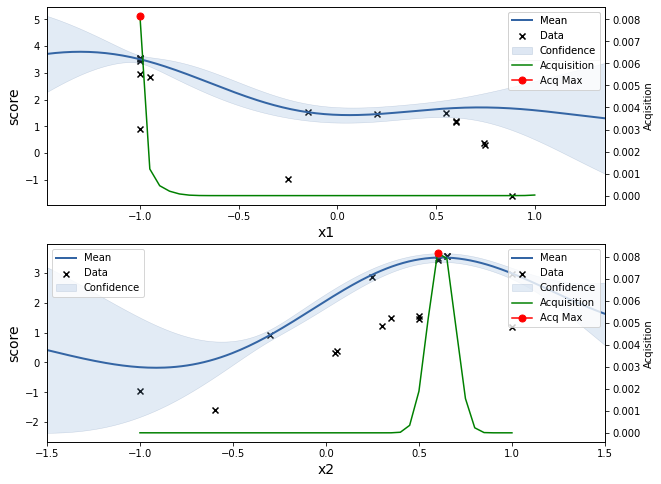

In [26]:
x, next_data = test.update_and_suggest_next_trial(x,next_data)

 C:\Users\183787\AppData\Roaming\Python\Python37\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


Next Trial:
x1: -1.0
x2: 0.6500000000000015


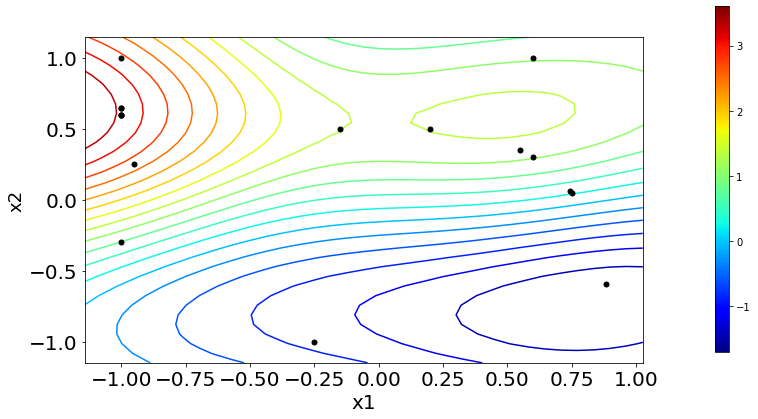

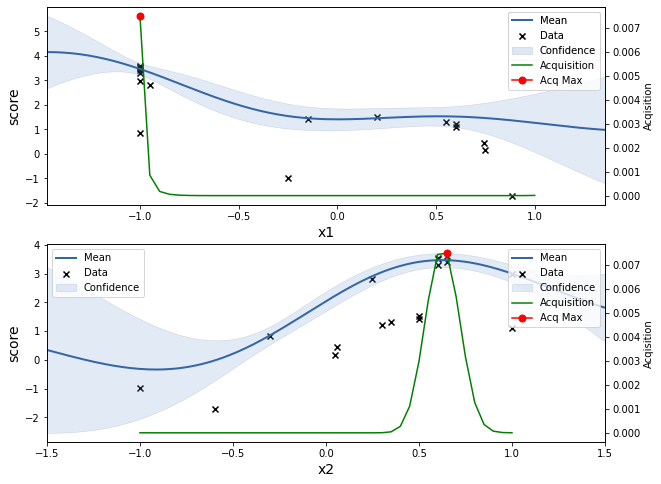

In [27]:
x, next_data = test.update_and_suggest_next_trial(x,next_data)

# 最終のモデル

 C:\Users\183787\AppData\Roaming\Python\Python37\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


GP_regression.,value,constraints,priors
sum.rbf.variance,1.2571699928579294,+ve,
sum.rbf.lengthscale,0.7515476847652498,+ve,
sum.white.variance,0.00410008825906506,+ve,
Gaussian_noise.variance,0.00410008825906506,+ve,


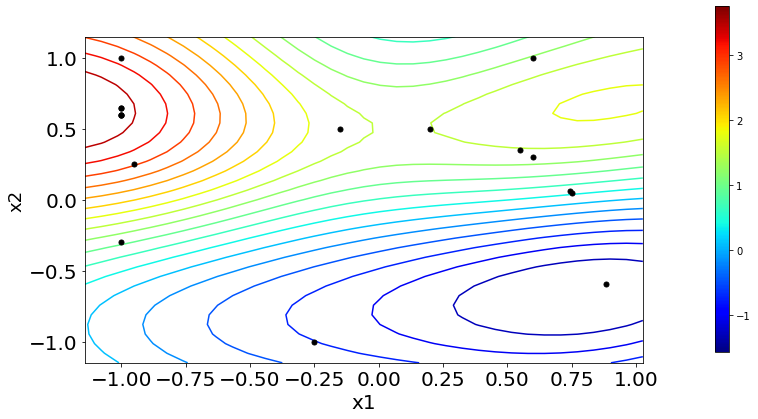

In [28]:
gpy_model = test.Gaussian_process_regression(x,test.f(x))
gpy_model

# 実験したデータと実際のYの値のプロット

In [29]:
# これまでのデータの予測値の最大値をBestとする。
y_pred,_=gpy_model.predict(x)

if orientation=="maximize":
    best_ind=np.argmax(y_pred)
elif orientation=="minimize":
    best_ind=np.argmin(y_pred)

best_experience = x[best_ind]

ind = np.ones(len(x), dtype=bool)
ind[best_ind] = False
print("最適な実験条件は{}です。".format(best_experience))

最適な実験条件は[-1.   0.6]です。


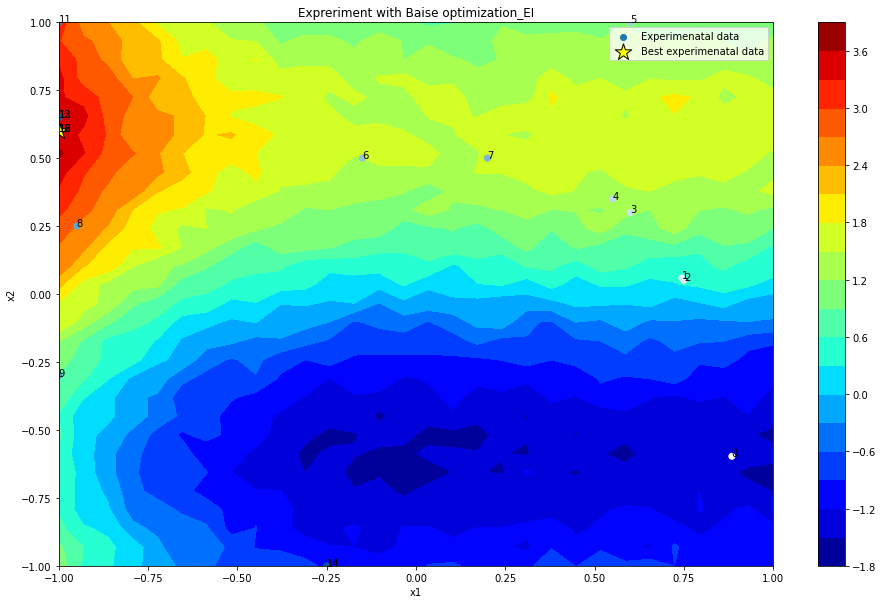

In [30]:
fig=plt.figure(figsize=(16,10))
plt=test.plot_f()
# 最適値以外をプロット
plt.scatter(x[ind,0],x[ind,1], c=np.arange(len(x))[1:] ,cmap='Blues', label="Experimenatal data")
for k, v in enumerate(x):
    plt.annotate(k,xy=(v[0],v[1]))
# 最適値をプロット
plt.scatter(best_experience[0],best_experience[1],marker="*", s=300, c="yellow",edgecolors="black",label="Best experimenatal data")
plt.legend()
plt.title("Expreriment with Baise optimization_{}".format(acq_name))
plt.show()

# 感想

UCB  
σの係数を1にしても結構活用を重視している印象を受けた。σとmuのバランスが恐らくデータによって違うので、係数をどう定めるべきかが難しそう。殆どの場合、最適解(-1,0.6)付近に落ち着くが、最初に与えらえるデータによっては、違うところに行くことがある。

EI  
結構探索をする印象を受けた。最適解を見つけることが多そう。

PI  
取れたデータ付近を中心に探索し(活用を重視している？)、素早く局所解の付近にたどり着く。

お勧めはEIな気がする。